In [11]:
!pip3 install polars pandana pandas pyrosm matplotlib numpy

In [1]:
import polars as pl
import os
import pandas as pd
import geopandas as gpd
from pyrosm import OSM, get_data
import numpy as np
import matplotlib.pyplot as plt
import pandana
from shapely.geometry import LineString

# Compute pairs of consecutive stops in the time table

## Load data

In [2]:
# GTFS data (used for timetable)
STATIC_GTFS_URL="https://eu.ftp.opendatasoft.com/stif/GTFS/IDFM-gtfs.zip"
STATIC_GTFS_FILE_PATH="raw_data/gtfs.zip"
STATIC_GTFS_PATH="raw_data/gtfs"

In [36]:
stop_times_path = os.path.join(STATIC_GTFS_PATH, 'stop_times.txt')
stop_times_cols = ['trip_id','stop_id','stop_sequence']
stop_times_dtype = {'trip_id': pl.String,
                    'stop_id': pl.String,
                    'stop_sequence': pl.Int16}
stop_times = pl.scan_csv(stop_times_path, schema_overrides=stop_times_dtype).select(stop_times_cols)

In [35]:
stops_path = os.path.join(STATIC_GTFS_PATH, 'stops.txt')
stops_dtype = {'stop_id': pl.String,
               'stop_lon': pl.Float64,
               'stop_lat': pl.Float64
               }
stops = pl.scan_csv(stops_path, schema_overrides=stops_dtype).select(list(stops_dtype.keys()))

# Compute graph of Ile-de-France driving network from OSM data

In [42]:
# Download data for Ile de France region from OpenStreetMap
idf_osm = OSM(get_data("Ile de France"))

In [43]:
# Parse street networks from OSM data
nodes, edges = idf_osm.get_network(nodes=True, network_type="driving")

In [24]:
# Export OSM network to routable graph
G = idf_osm.to_graph(nodes, edges, graph_type="pandana")

Generating contraction hierarchies with 1 threads.
Setting CH node vector of size 2172010
Setting CH edge vector of size 3874586
Range graph removed 3100764 edges of 7749172
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


In [25]:
# Save graph data
G.save_hdf5('data/osm_driving_network.h5')

In [92]:
# edges.to_parquet('data/osm_driving_edges.parquet')
# nodes.to_parquet('data/osm_driving_nodes.parquet')

## Load computed graph

In [25]:
# edges = pd.read_parquet('data/osm_driving_edges.parquet')
# nodes = pd.read_parquet('data/osm_driving_nodes.parquet')

In [5]:
G = pandana.Network.from_hdf5('data/osm_driving_network.h5')

Generating contraction hierarchies with 1 threads.
Setting CH node vector of size 2172010
Setting CH edge vector of size 3874586
Range graph removed 3100764 edges of 7749172
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


# Compute path between consecutive stops

## Get node in graph of each stop

In [37]:
stops_x_y = stops.select(['stop_lon', 'stop_lat']).collect().to_pandas()

In [38]:
# Get nearest graph node of all stops for selected bus line
node_ids = G.get_node_ids(stops_x_y.stop_lon.values, stops_x_y.stop_lat.values)

In [39]:
# Enrich stops dataframe
stops = stops.with_columns(pl.Series(name="node_id", values=node_ids))

## Enrich time table with stop data

In [40]:
stop_times = stop_times.join(stops, on='stop_id')

In [41]:
stop_times = stop_times.sort(['trip_id', 'stop_sequence'])

## Get consecutive stops pairs

In [42]:
stop_pairs = (
  pl.concat([stop_times.rename(lambda col: "orig_" + col),
             stop_times.rename(lambda col: "dest_" + col).shift(-1)],
             how='horizontal'
            )
  .filter(pl.col('orig_trip_id') == pl.col('dest_trip_id'))
  .filter(pl.col('orig_stop_sequence') < pl.col('dest_stop_sequence'))
  .filter(pl.col('orig_stop_id') != pl.col('dest_stop_id'))
  .drop(['orig_trip_id', 'dest_trip_id', 'orig_stop_sequence', 'dest_stop_sequence']).unique()
)
stop_pairs = stop_pairs.collect()
stop_pairs

orig_stop_id,orig_stop_lon,orig_stop_lat,orig_node_id,dest_stop_id,dest_stop_lon,dest_stop_lat,dest_node_id
str,f64,f64,i64,str,f64,f64,i64
"""IDFM:22493""",2.762003,48.852718,10791288258,"""IDFM:478492""",2.758723,48.854699,1579340034
"""IDFM:31558""",1.641536,48.667162,1372433894,"""IDFM:31565""",1.637522,48.665371,1372433906
"""IDFM:33488""",2.601911,48.585681,4895409073,"""IDFM:33490""",2.605809,48.584776,4895409071
"""IDFM:29562""",2.000119,49.125802,4781257390,"""IDFM:29546""",1.985352,49.138941,4781292156
"""IDFM:427704""",2.512458,48.987008,9360197129,"""IDFM:488042""",2.511824,48.984685,6781063040
…,…,…,…,…,…,…,…
"""IDFM:462583""",2.413757,48.617277,1346356912,"""IDFM:3781""",2.415037,48.613227,292760679
"""IDFM:19416""",2.54022,48.899259,8089782173,"""IDFM:19499""",2.547972,48.898722,8089782181
"""IDFM:420578""",2.375208,48.896192,6130070532,"""IDFM:488016""",2.357508,48.881466,9550005342


## Get paths

In [43]:
# Compute shortest path between consecutive stops
orig = stop_pairs['orig_node_id']
dest = stop_pairs['dest_node_id']
shortest = G.shortest_paths(orig, dest)

In [44]:
# Enrich stop_pairs with shortest path
stop_pairs = stop_pairs.with_columns(pl.Series(name="shortest_path", values=shortest))

### Convert paths to lists of position

In [45]:
shortest_pos = [G.nodes_df.loc[s.tolist()] for s in shortest]

In [46]:
# Enrich stop_pairs with shortest path positions
stop_pairs = stop_pairs.with_columns(pl.Series(name='shortest_path_pos', values=shortest_pos))
stop_pairs = stop_pairs.with_columns(pl.col('shortest_path_pos').map_elements(lambda x: LineString(x) if len(x) > 1 else None, return_dtype=pl.Object).alias("geometry"))

In [52]:
stop_pairs.head(3)

orig_stop_id,orig_stop_lon,orig_stop_lat,orig_node_id,dest_stop_id,dest_stop_lon,dest_stop_lat,dest_node_id,shortest_path,shortest_path_pos,geometry
str,f64,f64,i64,str,f64,f64,i64,list[i64],object,object
"""IDFM:22493""",2.762003,48.852718,10791288258,"""IDFM:478492""",2.758723,48.854699,1579340034,"[10791288258, 1579339994, … 1579340034]",x y 10791288258 2.762025 48.852638 1579339994 2.761872 48.852722 1579340008 2.760899 48.853275 254848346 2.760203 48.853668 1579340032 2.758890 48.854408 1579340034 2.758821 48.854446,"LINESTRING (2.7620251178741455 48.852638244628906, 2.7618720531463623 48.85272216796875, 2.760899305343628 48.853275299072266, 2.7602028846740723 48.853668212890625, 2.758890390396118 48.854408264160156, 2.7588205337524414 48.85444641113281)"
"""IDFM:31558""",1.641536,48.667162,1372433894,"""IDFM:31565""",1.637522,48.665371,1372433906,"[1372433894, 1372433895, … 1372433906]",x y 1372433894 1.641761 48.667282 1372433895 1.640190 48.666473 1372433902 1.639304 48.666061 1372433904 1.638237 48.665630 1372433906 1.637148 48.665203,"LINESTRING (1.641761302947998 48.66728210449219, 1.640189528465271 48.666473388671875, 1.6393043994903564 48.66606140136719, 1.6382367610931396 48.66563034057617, 1.637148141860962 48.66520309448242)"
"""IDFM:33488""",2.601911,48.585681,4895409073,"""IDFM:33490""",2.605809,48.584776,4895409071,"[4895409073, 1829984225, … 4895409071]",x y 4895409073 2.601869 48.585720 1829984225 2.602091 48.585682 2875907004 2.602188 48.585682 4403447103 2.602253 48.585682 4402799297 2.602319 48.585690 1829984219 2.602444 48.585709 2878064067 2.602615 48.585758 2875902867 2.602753 48.585800 11638481885 2.602793 48.585819 1829984333 2.602828 48.585835 1829984331 2.602861 48.585804 1829984279 2.602906 48.585785 1829984275 2.602958 48.585773 2702960685 2.603012 48.585777 2702960687 2.603063 48.585789 11638728046 2.603093 48.585762 2875902875 2.603115 48.585739 2875907021 2.603205 48.585659 2875907022 2.603337 48.585545 2875907023 2.603469 48.585430 2875907024 2.603602 48.585316 2875907025 2.603748 48.585197 2878004170 2.603849 48.585106 2878004171 2.603898 48.585064 2875907027 2.604003 48.584976 2875907028 2.604133 48.584862 2875907029 2.604266 48.584747 2875907030 2.604400 48.584633 2875907031 2.604533 48.584518 2875902887 2.604620 48.584560 5931379503 2.605462 48.584980 2875907054 2.605484 48.584991 2875907055 2.605570 48.584927 2875907056 2.605684 48.584900 2875907057 2.605783 48.584900 4895409071 2.605864 48.584831,"LINESTRING (2.6018688678741455 48.58572006225586, 2.602090835571289 48.5856819152832, 2.6021881103515625 48.5856819152832, 2.602252960205078 48.5856819152832, 2.6023190021514893 48.585689544677734, 2.6024441719055176 48.58570861816406, 2.602614641189575 48.585758209228516, 2.602753162384033 48.58580017089844, 2.6027934551239014 48.585819244384766, 2.60282826423645 48.58583450317383, 2.6028614044189453 48.5858039855957, 2.6029059886932373 48.585784912109375, 2.6029582023620605 48.58577346801758, 2.6030120849609375 48.585777282714844, 2.603062629699707 48.58578872680664, 2.603092908859253 48.58576202392578, 2.6031150817871094 48.58573913574219, 2.6032052040100098 48.58565902709961, 2.603337287902832 48.58554458618164, 2.6034693717956543 48.58543014526367, 2.603602170944214 48.5853157043457, 2.603747844696045 48.58519744873047, 2.603849411010742 48.585105895996094, 2.6038975715637207 48.58506393432617, 2.6040027141571045 48.58497619628906, 2.604133367538452 48.584861755371094, 2.6042661666870117 48.584747314453125, 2.604400396347046 48.584632873535156, 2.6045331954956055 48.58451843261719, 2.6046199798583984 48.58456039428711, 2.605461835861206 48.58498001098633, 2.6054844856262207 48.584991455078125, 2.605569839477539 48.58492660522461, 2.6056838035583496 48.58489990234375, 2.605782985687256 48.58489990234375, 2.6058638095855713 48.58483123779297)"


## Example

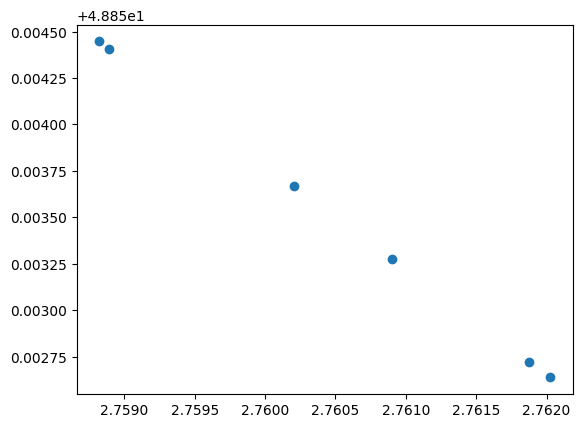

In [48]:
# Plot route
path_pos = G.nodes_df[G.nodes_df.index.isin(shortest[0])]

plt.scatter(path_pos.x, path_pos.y)
plt.show()

In [49]:
shortest[0]

array([10791288258,  1579339994,  1579340008,   254848346,  1579340032,
        1579340034])

In [50]:
G.nodes_df[G.nodes_df.index.isin(shortest[0])]

,x,y
10791288258,2.762025,48.852638
1579339994,2.761872,48.852722
1579340008,2.760899,48.853275
254848346,2.760203,48.853668
1579340032,2.758890,48.854408
1579340034,2.758821,48.854446


In [51]:
shortest_pos[0]

,x,y
10791288258,2.762025,48.852638
1579339994,2.761872,48.852722
1579340008,2.760899,48.853275
254848346,2.760203,48.853668
1579340032,2.758890,48.854408
1579340034,2.758821,48.854446
